In [29]:
# load Google Driver
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!rm -rf '/content/drive/My Drive/Colab Notebooks/EVA 5/09.Data Augmentation/__pycache__'
!ls -lrt '/content/drive/My Drive/Colab Notebooks/EVA 5/09.Data Augmentation/'

total 3206
-rw------- 1 root root    1902 Sep 26 20:31  dataAlbumentationLoad.py
-rw------- 1 root root    3712 Sep 26 21:03  VS_NET.py
-rw------- 1 root root    4480 Sep 26 21:03  Test_Train.py
-rw------- 1 root root    4482 Sep 26 21:03  Resnet.py
-rw------- 1 root root     599 Sep 26 21:03  README.md
-rw------- 1 root root    3165 Sep 26 21:03  Plots.py
-rw------- 1 root root    4771 Sep 26 21:03  dataTorchTransformLoad.py
-rw------- 1 root root  802739 Sep 26 21:03  01_CIFAR+Baseline.ipynb
drwx------ 2 root root    4096 Sep 26 21:04  outputs
-rw------- 1 root root  716011 Sep 26 21:05  02_CIFAR+Resnet.ipynb
-rw------- 1 root root 1733688 Sep 26 21:26 '02_CIFAR+Resnet _Gradcam.ipynb'


In [30]:
sys.path.append('/content/drive/My Drive/Colab Notebooks/EVA 5/09.Data Augmentation/')

In [32]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import sys
import random
import matplotlib

# import for all the modular codes
import Test_Train
import Plots
import dataTorchTransformLoad as dtl
import Resnet
import dataAlbumentationLoad as dal
#import GradCam



In [33]:
# -*- coding: utf-8 -*-
"""gradcam.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/15jNC5H3pI6Dd0UMS9fcREpMcMB7F9ljl
"""

import torch
import torch.nn.functional as F
import cv2

class GradCAM:
    """Calculate GradCAM salinecy map.
    Args:
        input: input image with shape of (1, 3, H, W)
        class_idx (int): class index for calculating GradCAM.
                If not specified, the class index that makes the highest model prediction score will be used.
    Return:
        mask: saliency map of the same spatial dimension with input
        logit: model output
    A simple example:
        # initialize a model, model_dict and gradcam
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        gradcam = GradCAM.from_config(model_type='resnet', arch=resnet, layer_name='layer4')
        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)
        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcam(normed_img, class_idx=10)
        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)
    """

    def __init__(self, model, layer_name):
        self.model = model
        # self.layer_name = layer_name
        self.target_layer = layer_name

        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]

        def forward_hook(module, input, output):
            self.activations['value'] = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    @classmethod
    def from_config(cls, arch: torch.nn.Module, model_type: str, layer_name: str):
        target_layer = layer_finders[model_type](arch, layer_name)
        return cls(arch, target_layer)

    def saliency_map_size(self, *input_size):
        device = next(self.model_arch.parameters()).device
        self.model(torch.zeros(1, 3, *input_size, device=device))
        return self.activations['value'].shape[2:]

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
        
        self.gradients.clear()
        self.activations.clear()
        return saliency_map, logit
    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

"""VISUALIZE_GRADCAM"""

def visualize_cam(mask, img, alpha=1.0):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b]) * alpha

    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result


# functions to show an image

# def imageshow(img):
#     # img = img / 2 + 0.5      #unnormalize
#     img[0] = img[0]*0.24703223 + 0.49139968
#     img[1] = img[1]*0.24348513 + 0.48215841
#     img[2] = img[2]*0.26158784 + 0.44653091
#     npimg = img.numpy()
#     plt.figure(figsize=(20,20))
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    plt.imshow(image)
    plt.grid(b=None)
    return image

def imshow1(img,c = "" ):
#img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  fig = plt.figure(figsize=(15,15))
  plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
  plt.title(c)
  plt.grid(b=None)

In [51]:
# # Modelling options for the loop


# d1 = {'NO L1&L1': [0.,0.,'model'],
#       'L1 Only': [1e-04,0.,'model'], 
#       'L2 Only': [0.,1e-04,'model'],
#       'L1&L2':[1e-04,1e-04,'model'],
#       'GBN Only': [0,0,'model2'],
#       'GBN with L1 and L2':[1e-04,1e-04,'model2']}

#initializers 
dropout_value = 0.05
num_splits=2
EPOCHS = 20
input_ch=3

metric_values = {}
models={}

batch_size_GPU=64
batch_size_CPU=16




In [45]:
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
train_transform = dal.AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1 )
                                       ])
# Test Phase transformations
test_transform = dal.AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [46]:
classes, trainloader, testloader = dal.load(train_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


In [47]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
    #print(vars(train_set))
print("Shape : ", train_set.data.shape)
print("Mean : ",train_set.data.mean(axis=(0,1,2))/255)
print("Std : ",train_set.data.std(axis=(0,1,2))/255)
print("Min : ",train_set.data.min(axis=(0,1,2))/255)
print("Max : ",train_set.data.max(axis=(0,1,2))/255)

Files already downloaded and verified
Shape :  (50000, 32, 32, 3)
Mean :  [0.49139968 0.48215841 0.44653091]
Std :  [0.24703223 0.24348513 0.26158784]
Min :  [0. 0. 0.]
Max :  [1. 1. 1.]


In [ ]:

# random.seed(1)
# # get some random training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# # show images
# random.seed(1)
# imageshow(torchvision.utils.make_grid(images))
# # print labels
# # print(' '.join('%5s' % classes[labels[j]] for j in range(64)))
# print(np.array([classes[labels[j]] for j in range(64)]).reshape(8,8))

<Figure size 432x288 with 0 Axes>

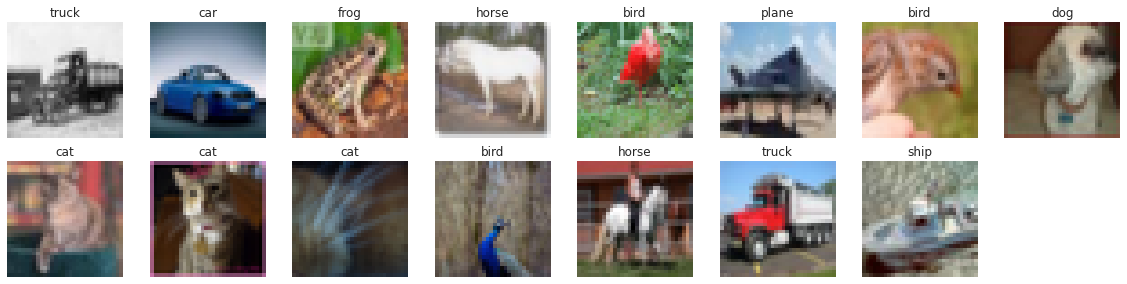

In [48]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# plt.style.use('dark_background')


figure = plt.figure()
plt.figure(figsize=(20,20))
num_of_images = 16
for index in range(1, num_of_images):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.title(classes[labels[index].item()])
    imshow(images[index])

In [ ]:
# # imshow(images[0])
# trans_ig = imshow(images[0])
# print(images[0].shape, trans_ig.shape)

#RESNET

In [49]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Resnet.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/content/drive/My Drive/Colab Notebooks/EVA 5/09.Data Augmentation/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


In [50]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.05)

In [52]:
exp_name = 'Resnet'

trainer = Test_Train.Trainer(model,device,train_loader,test_loader,optimizer,
                             EPOCHS,scheduler)
train_metric, test_metric = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary

metric_values[exp_name] = (train_metric, test_metric)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


/content/drive/My Drive/Colab Notebooks/EVA 5/09.Data Augmentation/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=0.8446680307388306 Batch_id=781 Accuracy=49.23: 100%|██████████| 782/782 [01:17<00:00, 10.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1818, Accuracy: 5901/10000 (59.01%)

EPOCH: 1
learning rate  [0.01]


Loss=0.49456772208213806 Batch_id=781 Accuracy=66.77: 100%|██████████| 782/782 [01:17<00:00, 10.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0113, Accuracy: 6675/10000 (66.75%)

EPOCH: 2
learning rate  [0.01]


Loss=1.1672489643096924 Batch_id=781 Accuracy=73.34: 100%|██████████| 782/782 [01:18<00:00, 10.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6645, Accuracy: 7702/10000 (77.02%)

EPOCH: 3
learning rate  [0.01]


Loss=0.4150810241699219 Batch_id=781 Accuracy=77.19: 100%|██████████| 782/782 [01:18<00:00,  9.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6077, Accuracy: 7928/10000 (79.28%)

EPOCH: 4
learning rate  [0.01]


Loss=0.45606228709220886 Batch_id=781 Accuracy=79.83: 100%|██████████| 782/782 [01:17<00:00, 10.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5064, Accuracy: 8292/10000 (82.92%)

EPOCH: 5
learning rate  [0.01]


Loss=0.607859194278717 Batch_id=781 Accuracy=81.70: 100%|██████████| 782/782 [01:17<00:00, 10.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5111, Accuracy: 8241/10000 (82.41%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.5105913877487183 Batch_id=781 Accuracy=86.56: 100%|██████████| 782/782 [01:17<00:00, 10.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3859, Accuracy: 8695/10000 (86.95%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.48116111755371094 Batch_id=781 Accuracy=87.57: 100%|██████████| 782/782 [01:17<00:00, 10.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3739, Accuracy: 8740/10000 (87.40%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.13723748922348022 Batch_id=781 Accuracy=88.17: 100%|██████████| 782/782 [01:17<00:00, 10.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3670, Accuracy: 8766/10000 (87.66%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.4883877635002136 Batch_id=781 Accuracy=88.53: 100%|██████████| 782/782 [01:17<00:00, 10.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3631, Accuracy: 8797/10000 (87.97%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.14751343429088593 Batch_id=781 Accuracy=89.02: 100%|██████████| 782/782 [01:17<00:00, 10.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3615, Accuracy: 8813/10000 (88.13%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.27603405714035034 Batch_id=781 Accuracy=89.34: 100%|██████████| 782/782 [01:17<00:00, 10.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3589, Accuracy: 8815/10000 (88.15%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.5171590447425842 Batch_id=781 Accuracy=89.54: 100%|██████████| 782/782 [01:17<00:00, 10.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3557, Accuracy: 8825/10000 (88.25%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.21783842146396637 Batch_id=781 Accuracy=89.70: 100%|██████████| 782/782 [01:17<00:00, 10.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3538, Accuracy: 8836/10000 (88.36%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.4282999038696289 Batch_id=781 Accuracy=89.73: 100%|██████████| 782/782 [01:17<00:00, 10.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3555, Accuracy: 8829/10000 (88.29%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.0945114865899086 Batch_id=781 Accuracy=89.75: 100%|██████████| 782/782 [01:17<00:00, 10.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3516, Accuracy: 8831/10000 (88.31%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.28073590993881226 Batch_id=781 Accuracy=89.79: 100%|██████████| 782/782 [01:17<00:00, 10.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3533, Accuracy: 8832/10000 (88.32%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.25799989700317383 Batch_id=781 Accuracy=89.52: 100%|██████████| 782/782 [01:17<00:00, 10.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3524, Accuracy: 8831/10000 (88.31%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.14078637957572937 Batch_id=781 Accuracy=89.77: 100%|██████████| 782/782 [01:17<00:00, 10.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3547, Accuracy: 8828/10000 (88.28%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.6134763956069946 Batch_id=781 Accuracy=89.61: 100%|██████████| 782/782 [01:17<00:00, 10.08it/s]



Test set: Average loss: 0.3548, Accuracy: 8831/10000 (88.31%)



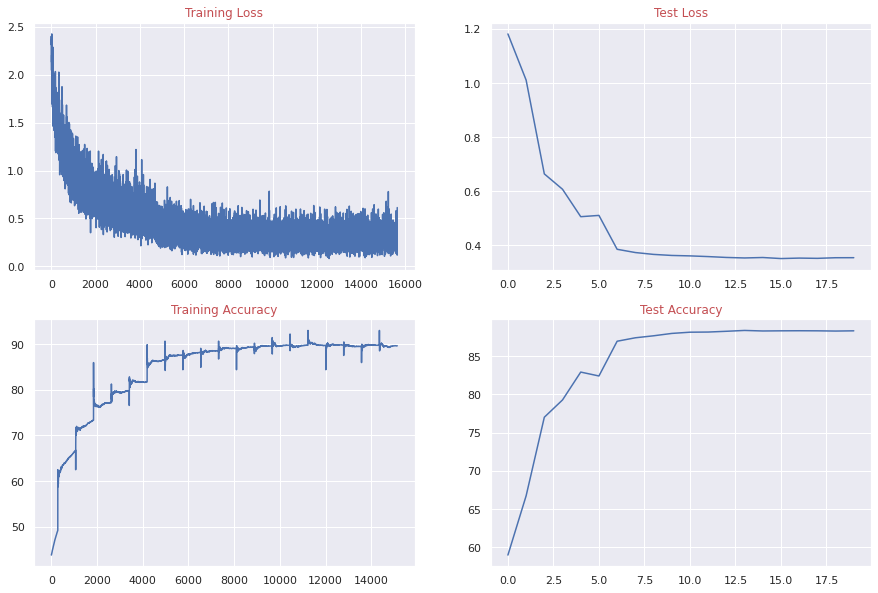

In [53]:
Plots.plot_metrics(train_metric, test_metric)

In [ ]:
# def im_unnormalize(img):
#   # img = img / 2 + 0.5     # unnormalize
#   img[0] = img[0]*0.24703223 + 0.49139968
#   img[1] = img[1]*0.24348513 + 0.48215841
#   img[2] = img[2]*0.26158784 + 0.44653091
#   npimg = img.numpy()
#   unnorm_img = np.transpose(npimg, (1, 2, 0))
#   return unnorm_img

# Plot misclassified

/content/drive/My Drive/Colab Notebooks/EVA 5/09.Data Augmentation/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


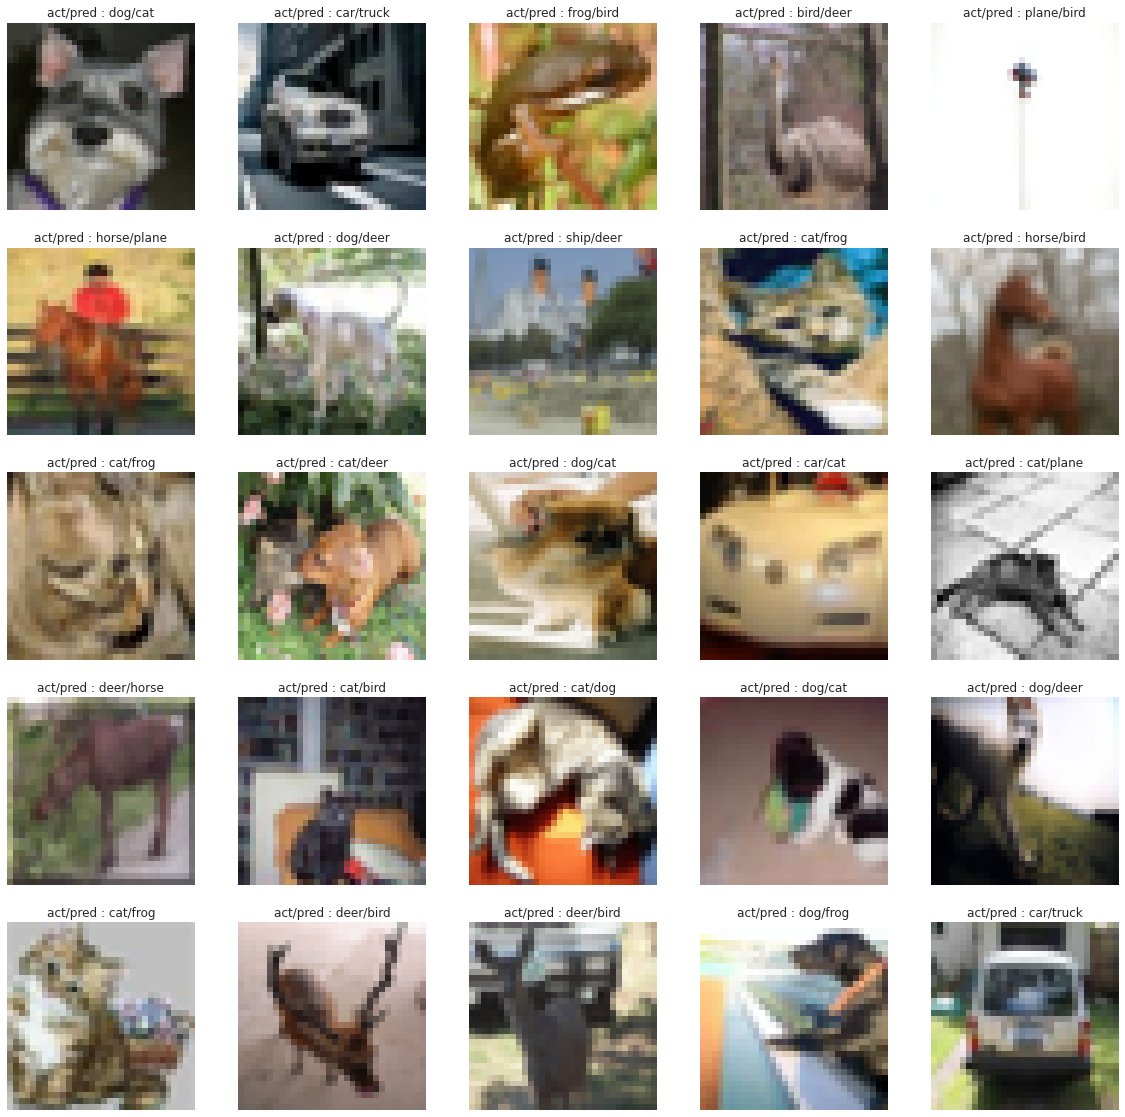

In [54]:

model.eval()

figure = plt.figure(figsize=(20, 20))
num_of_images = 25
index = 1

misclass_img_list = []
untrans_img=[]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(
            device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        act = target.view_as(pred)
        # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
        bool_vec = ~pred.eq(act)

        # now extract the index number from the tensor which has 'true'
        idx = list(
            np.where(bool_vec.cpu().numpy())[0])

        if idx:  # if not a blank list
            idx_list = idx
            # print(data[idx_list[0]].shape)
            if index < num_of_images+1:
                plt.subplot(5, 5, index)
                plt.axis('off')
                titl = 'act/pred : ' + \
                    str(classes[target[idx[0]].cpu().item(
                    )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                # prints the 1st index of each batch.
            
                img = data[idx[0]].cpu()
                untrans_img.append(img)
                image = imshow(img)
                misclass_img_list.append(image)
                                  


                plt.title(titl)
                index += 1


In [55]:
len(misclass_img_list)

25

# GEt one image from saved image - jpg
do the same transforms as ganapthy. 
get the grad cam


# get one data from test cifar
understand the dimensions of image that is passed if gradam works in real image
transform the cifar image


In [56]:
# dataiter = iter(test_loader)
# images, labels = dataiter.next()

# i = 5
# transformed_image1 = images[i].cpu()
# image1 = imshow(transformed_image1)
# plt.imshow(image1)
# # img_unnormalized = im_unnormalize(transformed_image1)

In [57]:
# Save misclassified image in local directory

# misclass_img_list
mis_img_name_list = []

for i in range(len(misclass_img_list)):
  img_name = 'mis_img'+str(i+1)+'.jpeg'
  mis_img_name_list.append(img_name)
  matplotlib.image.imsave(img_name, misclass_img_list[i])
  print(img_name)



mis_img1.jpeg
mis_img2.jpeg
mis_img3.jpeg
mis_img4.jpeg
mis_img5.jpeg
mis_img6.jpeg
mis_img7.jpeg
mis_img8.jpeg
mis_img9.jpeg
mis_img10.jpeg
mis_img11.jpeg
mis_img12.jpeg
mis_img13.jpeg
mis_img14.jpeg
mis_img15.jpeg
mis_img16.jpeg
mis_img17.jpeg
mis_img18.jpeg
mis_img19.jpeg
mis_img20.jpeg
mis_img21.jpeg
mis_img22.jpeg
mis_img23.jpeg
mis_img24.jpeg
mis_img25.jpeg


img1.jpeg
img2.jpeg
img3.jpeg
img4.jpeg


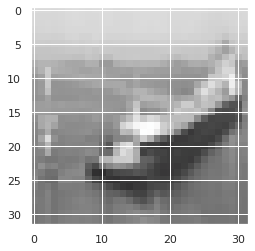

In [ ]:
# Image from Test Set - Save as jpg

# dataiter = iter(test_loader)
# images, labels = dataiter.next()

# # Save image

# img_list = []

# for i in range(4):
#   img_name = 'img'+str(i+1)+'.jpeg'
#   img_list.append(img_name)
#   matplotlib.image.imsave(img_name, imshow(images[i].cpu()))
#   print(img_name)

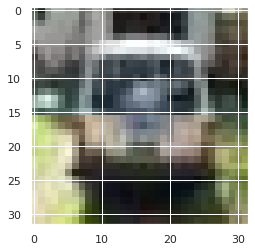

In [58]:
# Download PIL Images
import PIL

pil_image = []
for i,img in enumerate(mis_img_name_list):
   img = PIL.Image.open(img)
   pil_image.append(img)
   plt.imshow(img)


In [59]:
from torchvision import transforms
normed_torch_img = []
torch_img_list = []

for i in pil_image:
  torch_img = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])(i).to(device)
  torch_img_list.append(torch_img)
  normed_torch_img.append(transforms.Normalize([0.5, 0.5, 0.5], [0.24703223, 0.24348513, 0.26158784])(torch_img)[None])

/content/drive/My Drive/Colab Notebooks/EVA 5/09.Data Augmentation/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


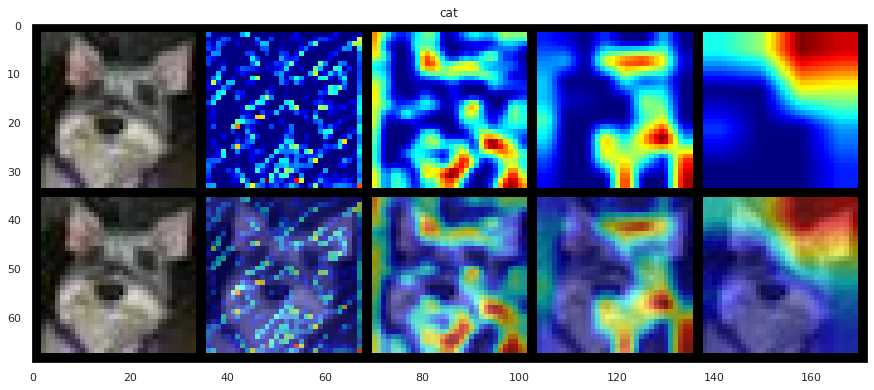

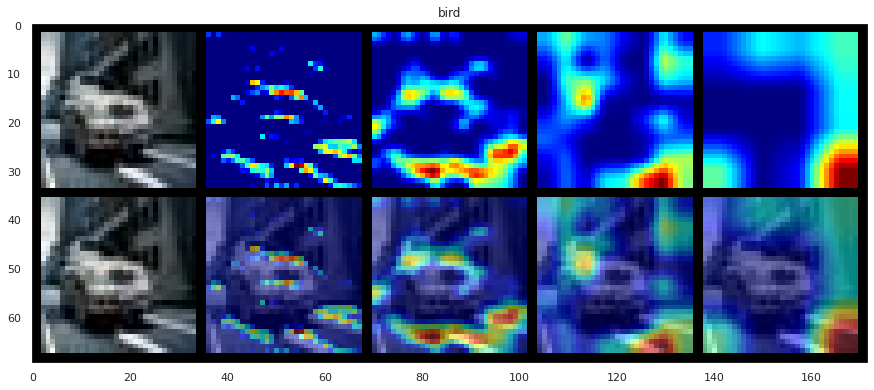

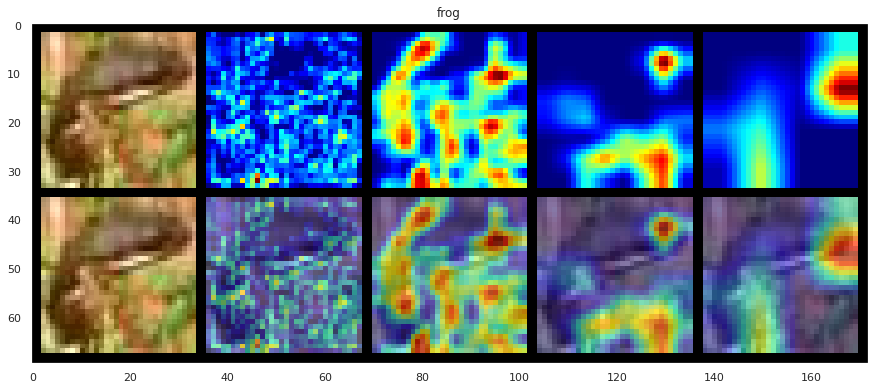

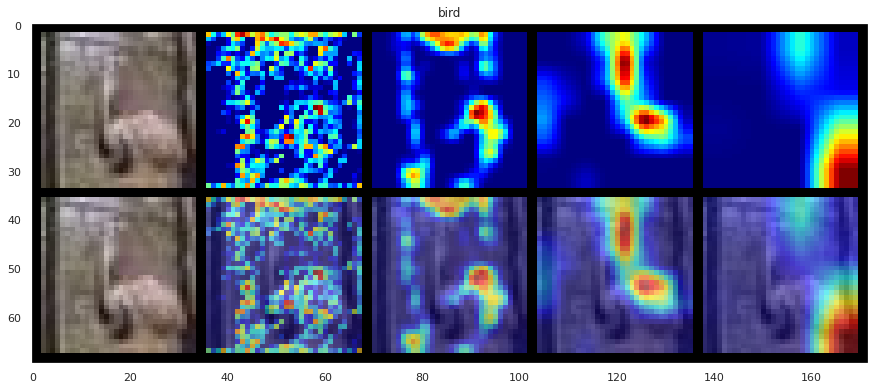

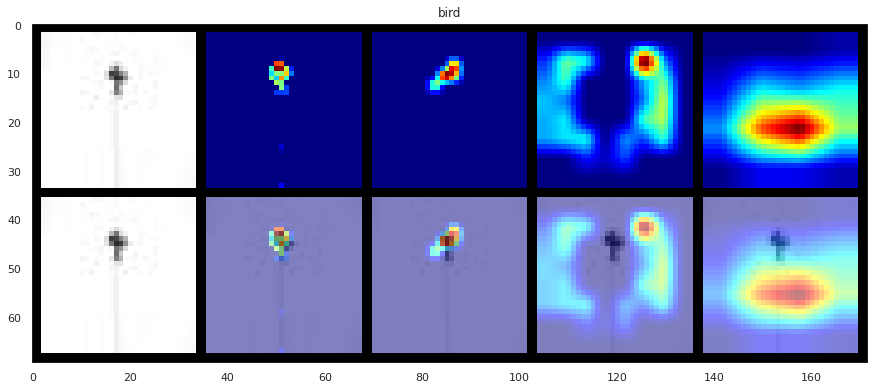

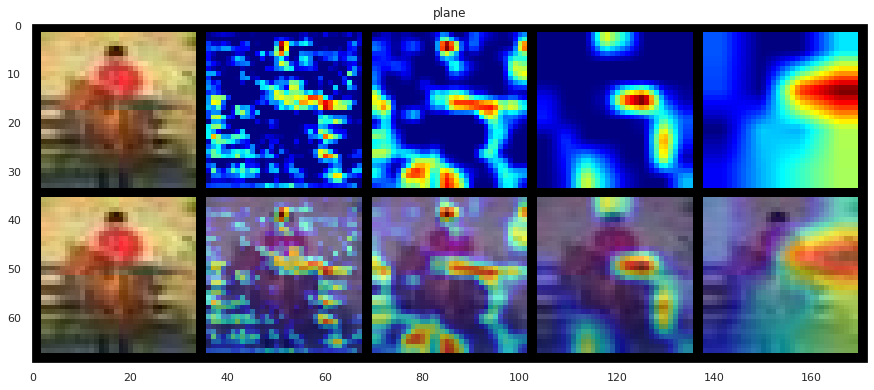

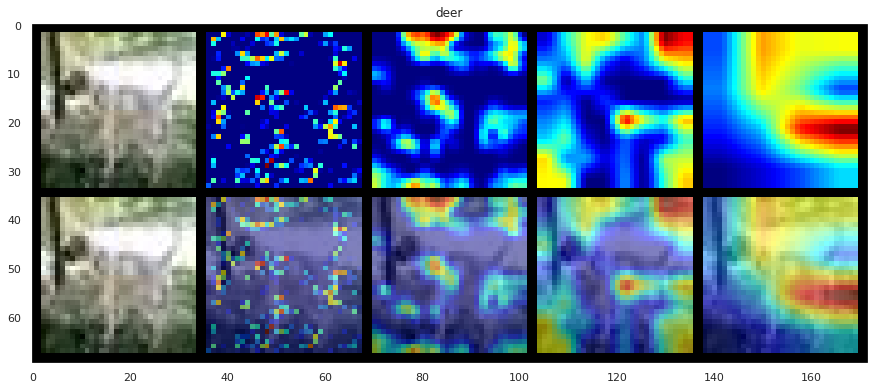

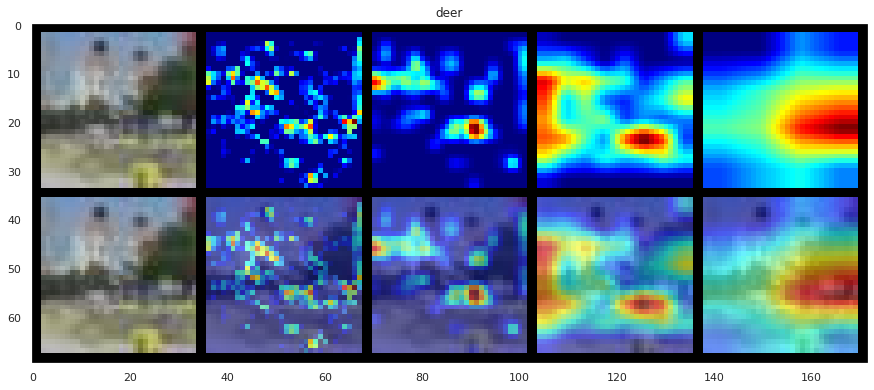

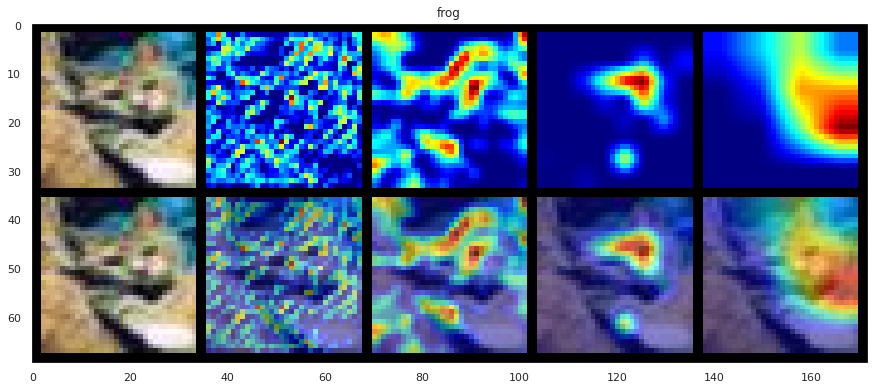

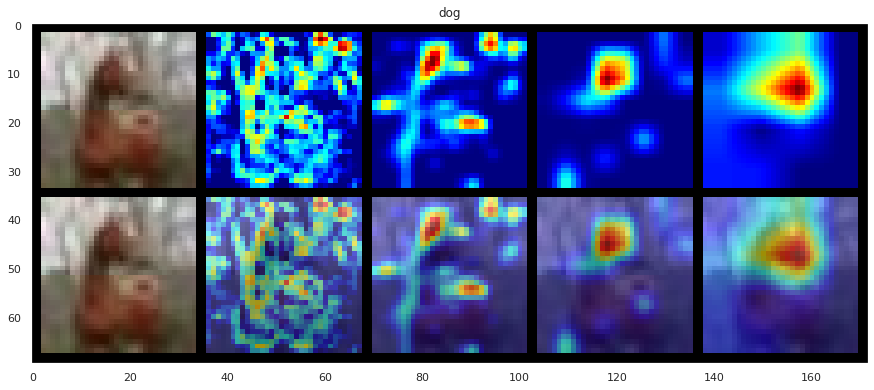

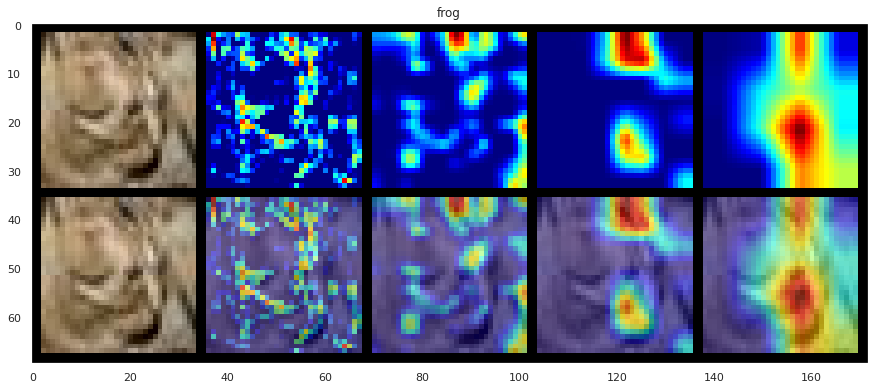

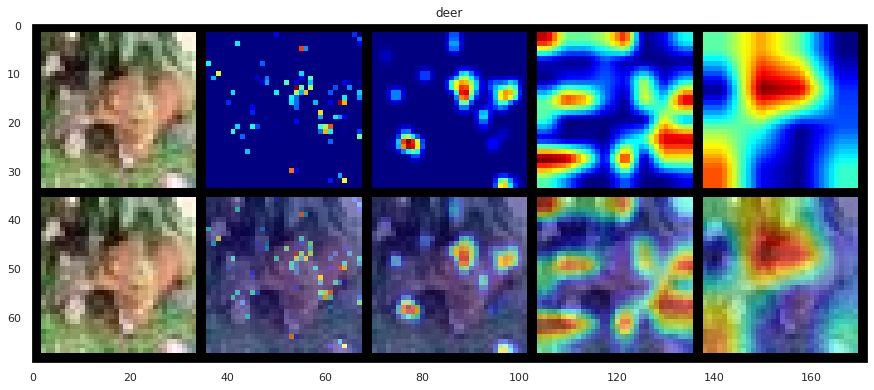

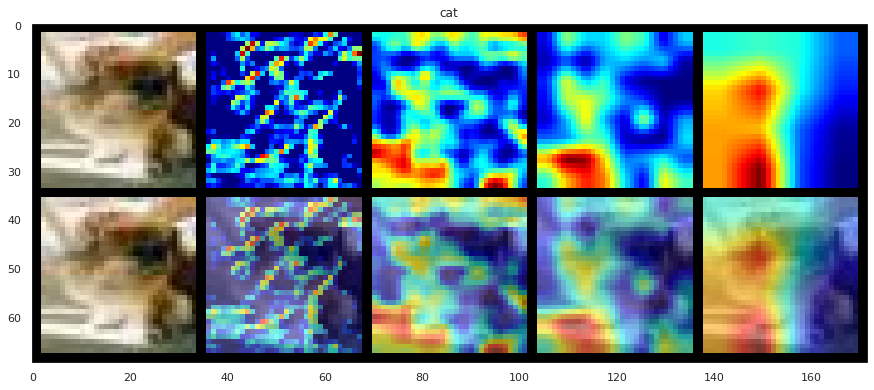

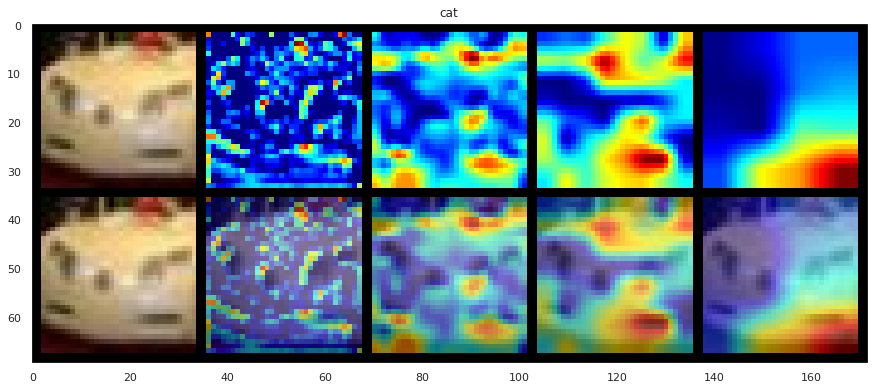

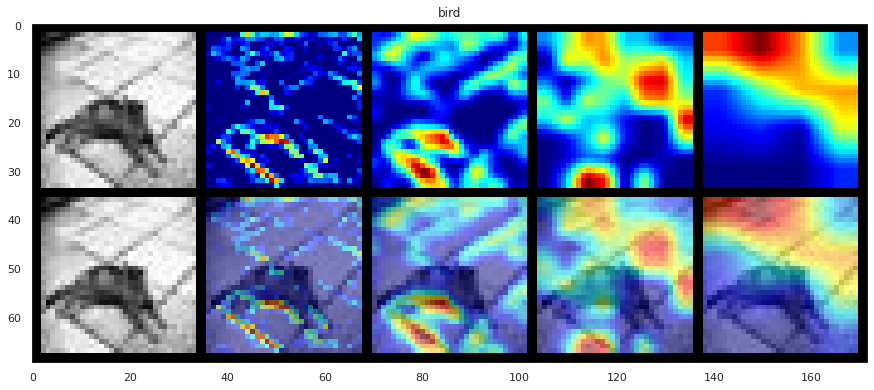

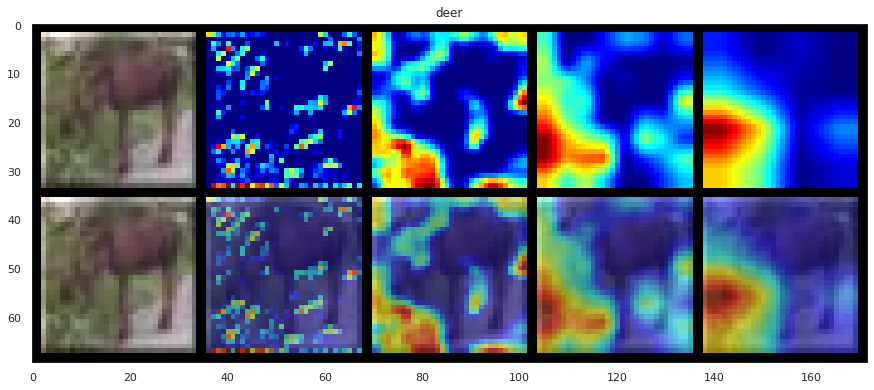

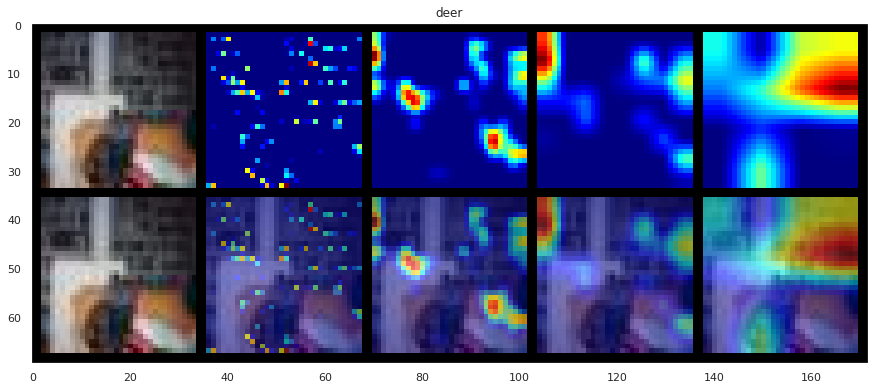

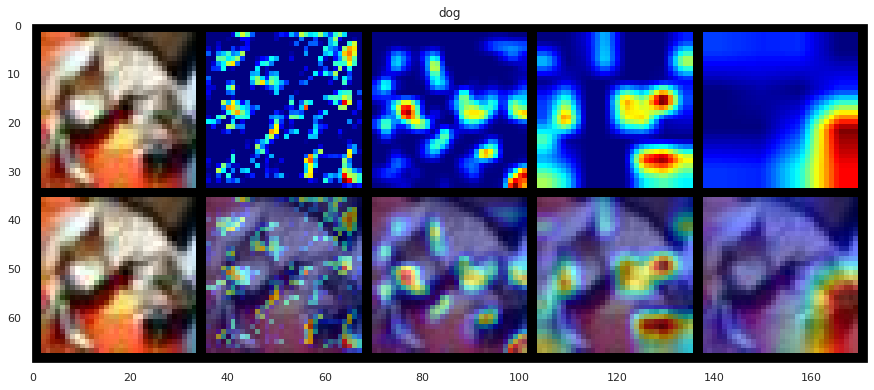

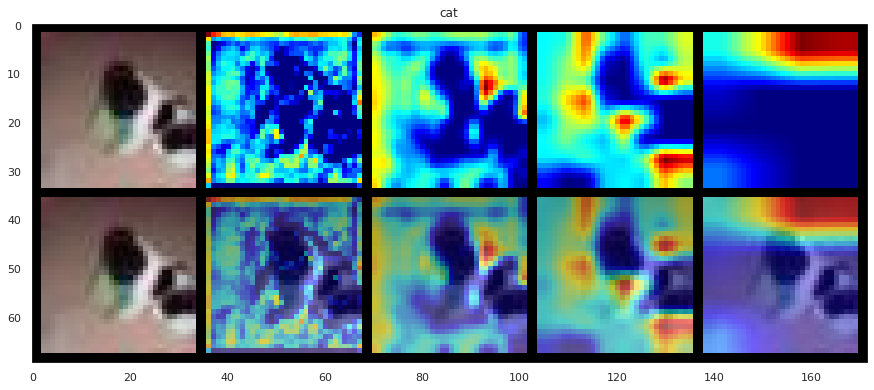

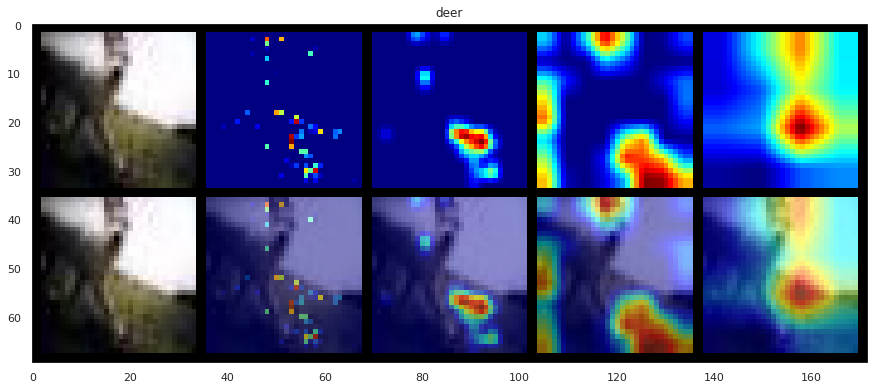

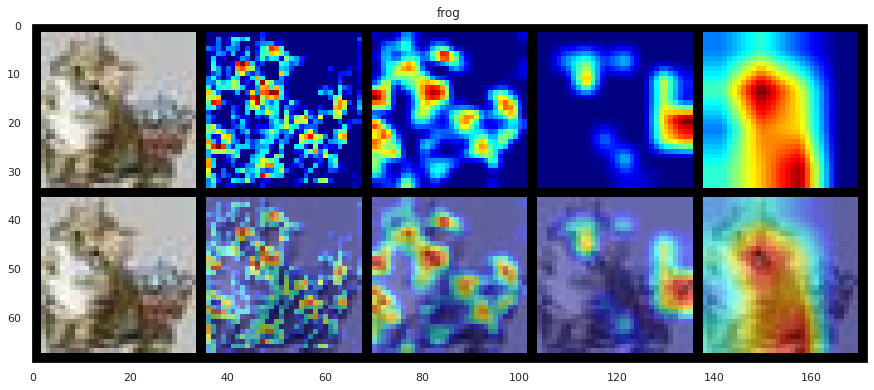

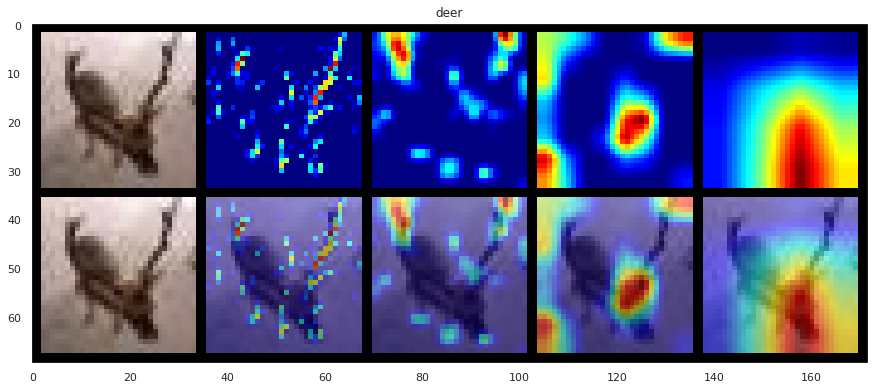

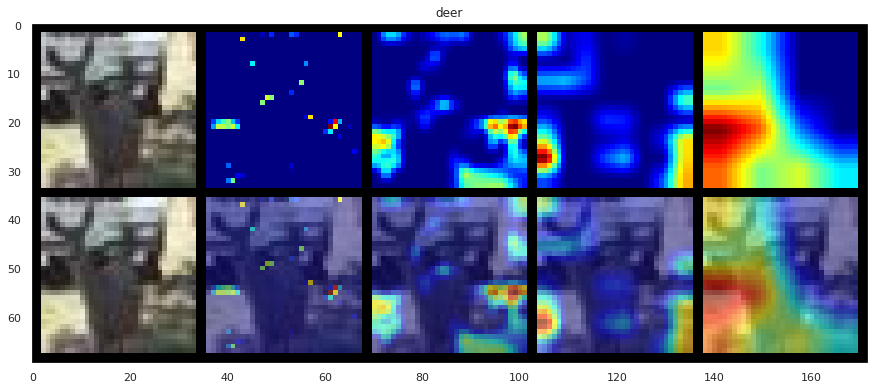

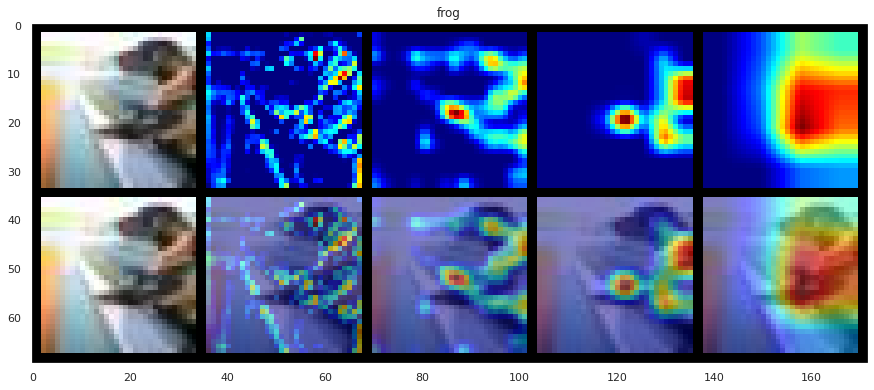

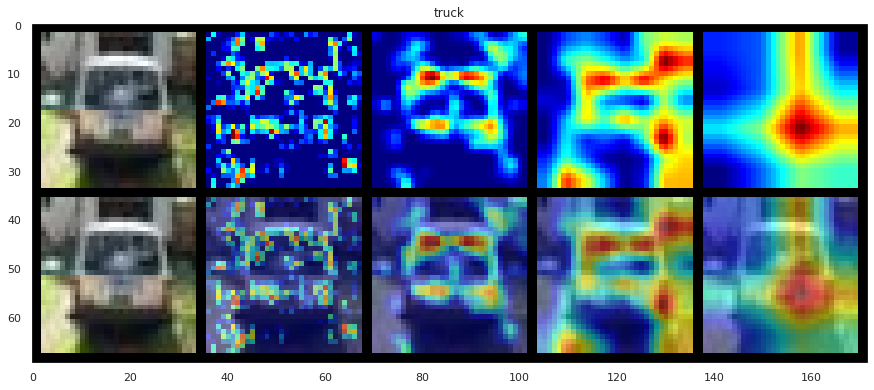

In [60]:

import copy
from torchvision.utils import make_grid, save_image

for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(normed_torch_img[i])
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
    

  grid_image = make_grid(images1+images2,nrow=5,padding=2,normalize=False)

  imshow1(grid_image,c = classes[int(predicted)])